In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, Bottleneck
from transformers import SamModel, SamProcessor

In [2]:
class Processor:
    def __init__(self):
        self.processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

    def preprocess(self, image):
        inputs = self.processor(image, return_tensors="pt")
        return inputs

    def postprocess(self, inputs, outputs):
        h, w = inputs['original_sizes'][0]

        resized = F.interpolate(
            outputs, size=(h, w),
            mode="bilinear", align_corners=True
        )

        resized = resized.squeeze(1)
        resized *= 255
        return resized


In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.sam = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")
        self.encoder = self.image_encoder
        self.decoder = self.initialize_decoder()

        # Freeze SAM encoder
        for param in self.sam.parameters():
            param.requires_grad = False

    def image_encoder(self, inputs):
        # Extract image embeddings using SAM
        # 256 x 64 x 64
        return self.sam.get_image_embeddings(inputs["pixel_values"])

    def initialize_decoder(self, use_bottleneck=False):
        # Choose block type: BasicBlock or Bottleneck
        Block = Bottleneck if use_bottleneck else BasicBlock

        upscale = nn.Sequential(
            # Upsample 256 x 64 x 64 -> 128 x 128 x 128
            nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            Block(inplanes=128, planes=128),  # Residual Block

            # Upsample 128 x 128 x 128 -> 64 x 256 x 256
            nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            Block(inplanes=64, planes=64),  # Residual Block

            # Reduce channels 64 x 256 x 256 -> 32 x 256 x 256
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            Block(inplanes=32, planes=32),  # Residual Block

            # Final output 32 x 256 x 256 -> 1 x 256 x 256
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        return upscale

    def forward(self, inputs):
        embeddings = self.encoder(inputs)
        depth = self.decoder(embeddings)
        return depth


# Example

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network().to(device)
processor = Processor()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [5]:
from PIL import Image
import requests

url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

inputs = processor.preprocess(image).to(device)
with torch.no_grad():
    outputs = model(inputs)
    prediction = processor.postprocess(inputs, outputs)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

image = np.array(image)
depth = np.array(prediction.squeeze(0).cpu().numpy()).astype("uint8")

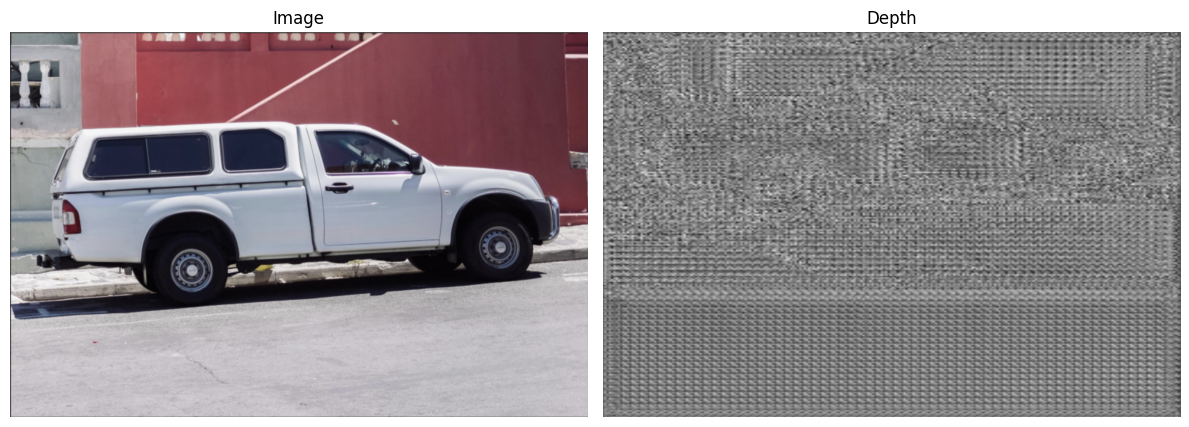

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(depth, cmap='gray')
axes[1].set_title("Depth")
axes[1].axis("off")

plt.tight_layout()
plt.show()
